# Reick Response Function Calculation

Space to develop code for Response function calculation as in Reick.

We will:

- Do a non-perturbed run to calculate average value of $z$
- For different forcing frequencies calculate the response, to then determine the response function

In [5]:
import tlorenz63 as tl63
from tlorenz63 import make_observations

# Standard Imports
import numpy as np
from scipy.stats import linregress
import os
import xarray as xr
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
# Parameter Choices

# Initialisation
X0=np.random.rand()
Y0=np.random.rand()
Z0=np.random.rand()
dx0=np.random.rand()
dy0=np.random.rand()
dz0=np.random.rand()

transient = 100
T = 500 # Integration time
dt = 5.e-3
num_obs = int(T/dt)
obs_freq = dt

In [7]:
# Perturbation Definitions
epsilons = [0.1, 0.5, 1]
frequencies = np.linspace(0.1, 12, 50)
omegas = [f * 2 * np.pi for f in frequencies]
switch_on_time = transient

def cos_perturbation(state, time, *args):
    eps = args[0]
    omega = args[1]
    x = state[0]
    perturbation = eps * np.cos(omega * time) * x
    return np.array([0, perturbation, 0])

def sin_impulse(state, t_state, time, *args):
    if (time == switch_on_time):
        print(f'Did Impulse at {time}')
        eps = args[0]
        omega = args[1]
        dx = t_state[0]
        perturbation = eps * np.sin(omega * time) * dx
        return np.array([0, perturbation, 0])
    return np.zeros(3) 

### Non Perturbation Run

Solving L63 with no perturbation.

In [8]:
# Definining Integrator and Observer

runner = tl63.Integrator(X_init=X0, Y_init=Y0, Z_init=Z0, dx_init=dx0, dy_init=dy0, dz_init=dz0, dt=dt)
looker = tl63.TrajectoryObserver(runner)

In [9]:
runner.integrate(transient)

In [10]:
make_observations(runner, looker, num_obs, obs_freq)
no_pert_obs = looker.observations

/rds/general/user/cfn18/home/L63-Linear-Response/tlorenz63.py:58: RuntimeWarning: overflow encountered in double_scalars
  dzdt = (Y * dx) + (X * dy) - (self.b * dz)
/rds/general/user/cfn18/home/L63-Linear-Response/tlorenz63.py:58: RuntimeWarning: invalid value encountered in double_scalars
  dzdt = (Y * dx) + (X * dy) - (self.b * dz)


In [11]:
eq_mean = no_pert_obs.Z.mean()

In [8]:
# # Performing Perturbation Run for varying strengths of epsilon

# perturbed_observations = []
# strengths = [1.e-6, 1.e-5, 1.e-4, 1.e-3, 1.e-2, 0.1, 0.5, 0.7, 1, 2, 5]
# for eps in tqdm(strengths):
#     print(f'Working on run with eps = {eps}')
#     runner = tl63.PerturbedIntegrator(perturbation_field=cos_perturbation, p_args=[eps, omega], t_perturbation_field=sin_impulse,
#             tp_args=[eps, omega], X_init=X0, Y_init=Y0, Z_init=Z0, dx_init=dx0, dy_init=dy0, dz_init=dz0)
#     looker = tl63.TrajectoryObserver(runner)
#     runner.integrate(transient)
#     runner.perturbation_on = True
#     perturbation_on_time = runner.time
#     make_observations(runner, looker, num_obs, obs_freq)
#     observations = looker.observations
#     observations.attrs.update({'eps': eps})        
#     epsilon = observations.attrs['eps']
#     save = f'Reick-Experiment/Perturbed-Run-Trajectory/Eps_{epsilon:.1e}'.replace('.','_')
#     observations.to_netcdf(save + '.nc')
#     print(f'Saved to {save}')

In [42]:
# eps = epsilons[1]
# omega = omegas[10]

# print(f'Working on run with eps = {eps:.2f}, Omega = {omega:.1e}')

# # Save Directory, determined by epsilon


# home = os.path.expanduser("~")
# dirName = home + f'/L63-Linear-Response/Response-Function-Reick/eps{eps:.2f}/'.replace('.','_')
# if not os.path.exists(dirName):
#     os.makedirs(dirName, exist_ok=True)
#     print("Directory " , dirName ,  " Created ")
# else:    
#     print("Directory " , dirName ,  " already exists")


# # # Definining Runner and Looker
# runner = tl63.PerturbedIntegrator(perturbation_field=cos_perturbation, p_args=[eps, omega], t_perturbation_field=sin_impulse,
#             tp_args=[eps, omega], X_init=X0, Y_init=Y0, Z_init=Z0, dx_init=dx0, dy_init=dy0, dz_init=dz0)
# looker = tl63.TrajectoryObserver(runner)

# # Perforiming Integrations
# print('Beginning Transient')
# runner.integrate(transient)

# print('Transient finished. Starting integration')
# runner.perturbation_on = True
# perturbation_on_time = runner.time
# make_observations(runner, looker, num_obs, obs_freq)

# # # Saving Output
# observations = looker.observations
# observations.attrs.update({'eps': eps, 'omega': omega})        
# epsilon = observations.attrs['eps']
# omega = observations.attrs['omega']

# save = f'Omega_{omega:.1e}'.replace('.','_')
# observations.to_netcdf(dirName + save + '.nc')
# print(f'Saved to {dirName + save}.nc')

In [10]:
# Time series of responses
def fetch_ts(file):
    omega = []
    response_ts = []
    for data in tqdm(perturbed_data):
        response = data.Z - eq_mean
        response_ts.append(response)
    return response_ts

# condition = epsilon * omega * (data.Time.max() - data.Time.min()).item()
# conditions.append(condition)
# power = np.abs(2 * np.mean(np.exp(data.Time * omega * 1j) * data)/epsilon)
# powers.append(power.item())

# Plot of Response Function Power

In [11]:
os.listdir('Response-Function-Reick')

['eps0_10', 'eps0_50', 'eps1_00']

In [12]:
# Collect response power to different frequency forcing

epsilons = [0.1, 0.5, 1]
response_power = []
for i, d in enumerate(os.listdir('Response-Function-Reick')):
    directory = f'Response-Function-Reick/{d}/'
    epsilon = epsilons[i]
    print(f'Working with epsilon {epsilon}')
    frequencies = []
    powers = []
    for file in tqdm(os.listdir(directory)):
        ds = xr.open_dataset(directory + file)
        response_ts = ds.Z - eq_mean
        freq = ds.omega/(2 * np.pi)
        frequencies.append(freq)
        power = np.abs(2 * np.mean(np.exp(ds.Time * ds.omega * 1j) * response_ts)/epsilon)
        powers.append(power.item())
    da = xr.DataArray(powers, coords={'Frequency': frequencies}, dims = ['Frequency'],
              name='Response Power', attrs = {'Eps': epsilon})
    response_power.append(da.sortby(da.Frequency))

Working with epsilon 0.1



Working with epsilon 0.5



Working with epsilon 1


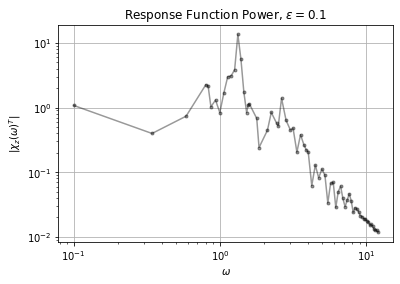

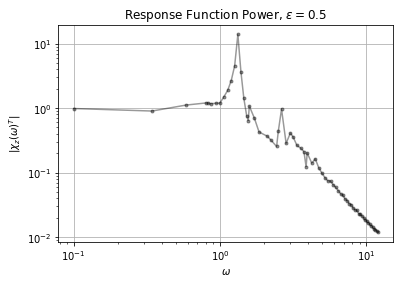

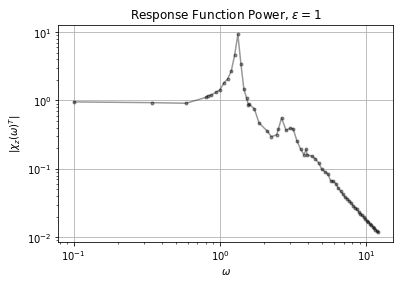

In [15]:
for da in response_power:
    plt.plot(da.Frequency, da, 'k.-', alpha = 0.4)
    plt.grid()
    plt.xlabel('$\\omega$')
    plt.ylabel('$|\\chi_z (\\omega)^T|$')
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Response Function Power, $\\epsilon=${da.Eps}')
    plt.show()